In [18]:
import pandas as pd
import json
import re

# Read the JSON files
with open('val_predictions_lora.json', 'r') as f:
    lora_data = json.load(f)
    
with open('val_predictions.json', 'r') as f:
    non_lora_data = json.load(f)
# Convert to dataframes
lora_df = pd.DataFrame(lora_data)
non_lora_df = pd.DataFrame(non_lora_data)

# Add lora_response column to non_lora_df
lora_df['non_lora_response'] = non_lora_df['non_lora_response']

# Rename for clarity
val_predictions_df = lora_df




In [19]:
val_predictions_df


,instruction,input,output,complete-text,narrative_id,query,lora_response,non_lora_response
0,### INSTRUCTIONS\n You are a helpful as...,"### INPUT \n Story, broken down into nu...",### Task 1: Identify the Protagonist\nThe prot...,### INSTRUCTIONS\n You are a helpful as...,7800148,### INSTRUCTIONS\n You are a helpful as...,### INSTRUCTIONS\n You are a helpful as...,assistant\n\n### Task 1: Identify the Protagon...
1,### INSTRUCTIONS\n You are a helpful as...,"### INPUT \n Story, broken down into nu...",### 1. Identification of the Protagonist\nThe ...,### INSTRUCTIONS\n You are a helpful as...,63144886,### INSTRUCTIONS\n You are a helpful as...,### INSTRUCTIONS\n You are a helpful as...,assistant\n\n### Identification of Protagonist...
2,### INSTRUCTIONS\n You are a helpful as...,"### INPUT \n Story, broken down into nu...",### 1. Identification of the Protagonist\nThe ...,### INSTRUCTIONS\n You are a helpful as...,19892645,### INSTRUCTIONS\n You are a helpful as...,### INSTRUCTIONS\n You are a helpful as...,assistant\n\n### 1. Identification of Protagon...
3,### INSTRUCTIONS\n You are a helpful as...,"### INPUT \n Story, broken down into nu...",### 1. Identification of Protagonist or Centra...,### INSTRUCTIONS\n You are a helpful as...,90474198,### INSTRUCTIONS\n You are a helpful as...,### INSTRUCTIONS\n You are a helpful as...,assistant\n\n### 1. Identification of Protagon...
4,### INSTRUCTIONS\n You are a helpful as...,"### INPUT \n Story, broken down into nu...",### 1. Identification of the Protagonist\nThe ...,### INSTRUCTIONS\n You are a helpful as...,60357421,### INSTRUCTIONS\n You are a helpful as...,### INSTRUCTIONS\n You are a helpful as...,assistant\n\n### Task 1: Identify the Protagon...
...,...,...,...,...,...,...,...,...
83,### INSTRUCTIONS\n You are a helpful as...,"### INPUT \n Story, broken down into nu...",### Task 1: Identify the Protagonist or Centra...,### INSTRUCTIONS\n You are a helpful as...,60246522,### INSTRUCTIONS\n You are a helpful as...,### INSTRUCTIONS\n You are a helpful as...,assistant\n\n### TASK 1: Identify the Protagon...
84,### INSTRUCTIONS\n You are a helpful as...,"### INPUT \n Story, broken down into nu...",### 1. Identification of Protagonist or Centra...,### INSTRUCTIONS\n You are a helpful as...,50480732,### INSTRUCTIONS\n You are a helpful as...,### INSTRUCTIONS\n You are a helpful as...,assistant\n\n### 1. Identify the protagonist o...
85,### INSTRUCTIONS\n You are a helpful as...,"### INPUT \n Story, broken down into nu...",### 1. Identification of the Protagonist\nThe ...,### INSTRUCTIONS\n You are a helpful as...,61027838,### INSTRUCTIONS\n You are a helpful as...,### INSTRUCTIONS\n You are a helpful as...,assistant\n\n### 1. Identification of Protagon...
86,### INSTRUCTIONS\n You are a helpful as...,"### INPUT \n Story, broken down into nu...",### 1. Identification of the Protagonist\nThe ...,### INSTRUCTIONS\n You are a helpful as...,61253857,### INSTRUCTIONS\n You are a helpful as...,### INSTRUCTIONS\n You are a helpful as...,assistant\n\n### Identification of Turning Poi...


In [41]:
val_predictions_df.iloc[0]['extracted_tp_non_lora']


'{tp1: 3.0, tp2: 4.0, tp3: 16.0, tp4: 21.0, tp5: 36.0}'

In [40]:
import asyncio
from openai import AsyncOpenAI

# Extract JSON from responses using OpenAI API
async def clean_json_output(text):
    """Extract JSON-formatted turning points using LLM."""
    if pd.isna(text):
        return None
        
    client = AsyncOpenAI(
        api_key="secret_narratives_652fe4188cfa48a89d8e941099004552.hs4awlXceqOliqZFCWKMV38luOnduxXr",
        base_url="https://api.lambdalabs.com/v1"
    )

    # # Extract only the response portion after "### RESPONSE"
    # response_match = re.search(r'### RESPONSE\s*(.*)', text, re.DOTALL)
    # if response_match:
    #     text = response_match.group(1).strip()
    # print(text)
    
    try:
        response = await client.chat.completions.create(
            model="llama3.3-70b-instruct-fp8",
            messages=[{
                "role": "system",
                "content": "Extract the determined 5 turning point sentence locations in the response and format them as JSON object from the given text. Return only valid JSON. It should be in the raw format of {tp1: ##.#, tp2: ##.#, tp3: ##.#, tp4: ##.#, tp5: ##.#}"
            },
            {
                "role": "user", 
                "content": f"Extract the turning points in the text into valid JSON:\n{text}"
            }]

        )
        print(response.choices[0].message.content)
        return json.loads(response.choices[0].message.content)
    except:
        return response.choices[0].message.content


# Process all rows asynchronously
async def process_all_rows():
    # non_lora_results = await asyncio.gather(*[clean_json_output(text) for text in val_predictions_df['non_lora_response']])
    lora_results = await asyncio.gather(*[clean_json_output(text) for text in val_predictions_df['lora_response']])
    non_lora_results = await asyncio.gather(*[clean_json_output(text) for text in val_predictions_df['non_lora_response']])
    # Add results to dataframe
    # val_predictions_df['extracted_tp_non_lora'] = non_lora_results
    val_predictions_df['extracted_tp_lora'] = lora_results
    val_predictions_df['extracted_tp_non_lora'] = non_lora_results
    
await process_all_rows()

{'tp1': 4.0, 'tp2': 8.0, 'tp3': 11.0, 'tp4': 14.0, 'tp5': 20.0}
{'tp1': 14, 'tp2': 16, 'tp3': 20, 'tp4': 22, 'tp5': 35}
{'tp1': 6.0, 'tp2': 7.0, 'tp3': 8.0, 'tp4': 11.0, 'tp5': 14.0}
{"tp1": 3.0, "tp2": 6.0, "tp3": 10.0, "tp4": 14.0, "tp5": 15.0}
{"tp1": 3.0, "tp2": 4.0, "tp3": 16.0, "tp4": 22.0, "tp5": 34.0}
{'tp1': 8.0, 'tp2': 11.0, 'tp3': 19.0, 'tp4': 22.0, 'tp5': 31.0}
{"tp1": 6.0, "tp2": 10.0, "tp3": 16.0, "tp4": 13.0, "tp5": 21.0}
{"tp1": 5.0, "tp2": 11.0, "tp3": 14.0, "tp4": 20.0, "tp5": 28.0}
{"tp1": 8.0, "tp2": 14.0, "tp3": 24.0, "tp4": 27.0, "tp5": 30.0}
```json
{tp1: 13.0, tp2: 16.0, tp3: 26.0, tp4: 31.0, tp5: 33.0}
```
{"tp1": 6.0, "tp2": 7.0, "tp3": 13.0, "tp4": 18.0, "tp5": 25.0}
{'tp1': 3.0, 'tp2': 13.0, 'tp3': 17.0, 'tp4': 20.0, 'tp5': 25.0}
{"tp1": 4.0, "tp2": 6.0, "tp3": 14.0, "tp4": 27.0, "tp5": 32.0}
{"tp1": 5.0, "tp2": 8.0, "tp3": 15.0, "tp4": 19.0, "tp5": 28.0}
{"tp1": 4.0, "tp2": 6.0, "tp3": 12.0, "tp4": 14.0, "tp5": 27.0}
{"tp1": 7.0, "tp2": 11.0, "tp3": 17.0, "

In [42]:
# Count number of None values in extracted columns
none_counts = {
    'extracted_tp_lora': val_predictions_df['extracted_tp_lora'].isna().sum(),
    'extracted_tp_non_lora': val_predictions_df['extracted_tp_non_lora'].isna().sum()
}
print("Number of None values in extracted columns:")
for col, count in none_counts.items():
    print(f"{col}: {count}")

# Display full dataframe
val_predictions_df

Number of None values in extracted columns:
extracted_tp_lora: 0
extracted_tp_non_lora: 0


,instruction,input,output,complete-text,narrative_id,query,lora_response,non_lora_response,extracted_tp_lora,extracted_tp_non_lora,v2-extracted_tp_non_lora,v2-extracted_tp_lora,synopsis,synopsis_len,turning_points
0,### INSTRUCTIONS\n You are a helpful as...,"### INPUT \n Story, broken down into nu...",### Task 1: Identify the Protagonist\nThe prot...,### INSTRUCTIONS\n You are a helpful as...,7800148,### INSTRUCTIONS\n You are a helpful as...,### INSTRUCTIONS\n You are a helpful as...,assistant\n\n### Task 1: Identify the Protagon...,"```json\n{""tp1"": 4.0, ""tp2"": 8.0, ""tp3"": 12.0,...","{tp1: 3.0, tp2: 4.0, tp3: 16.0, tp4: 21.0, tp5...","{'tp1': 1.0, 'tp2': 3.0, 'tp3': 2.0, 'tp4': 4....","{'tp1': 4.0, 'tp2': 8.0, 'tp3': 12.0, 'tp4': 1...",[The narrative commences in the transformative...,26,"{'tp1': 4.0, 'tp2': 6.0, 'tp3': 14.0, 'tp4': 1..."
1,### INSTRUCTIONS\n You are a helpful as...,"### INPUT \n Story, broken down into nu...",### 1. Identification of the Protagonist\nThe ...,### INSTRUCTIONS\n You are a helpful as...,63144886,### INSTRUCTIONS\n You are a helpful as...,### INSTRUCTIONS\n You are a helpful as...,assistant\n\n### Identification of Protagonist...,"{'tp1': 6.0, 'tp2': 11.0, 'tp3': 16.0, 'tp4': ...","```json\n{""tp1"": 4.0, ""tp2"": 6.0, ""tp3"": 10.0,...","{'tp1': 1.0, 'tp2': 4.0, 'tp3': 2.0, 'tp4': 6....","{'tp1': 6.0, 'tp2': 11.0, 'tp3': 16.0, 'tp4': ...",[Nestled in the heart of Massachusetts is the ...,36,"{'tp1': 7.0, 'tp2': 12.0, 'tp3': 16.0, 'tp4': ..."
2,### INSTRUCTIONS\n You are a helpful as...,"### INPUT \n Story, broken down into nu...",### 1. Identification of the Protagonist\nThe ...,### INSTRUCTIONS\n You are a helpful as...,19892645,### INSTRUCTIONS\n You are a helpful as...,### INSTRUCTIONS\n You are a helpful as...,assistant\n\n### 1. Identification of Protagon...,"```json\n{\n ""tp1"": 5.0,\n ""tp2"": 8.0,\n ""t...","{tp1: 4, tp2: 6, tp3: 16, tp4: 20, tp5: 25}","{'tp1': 1.0, 'tp2': 4.0, 'tp3': 2.0, 'tp4': 6....","{'tp1': 5.0, 'tp2': 8.0, 'tp3': 12.0, 'tp4': 1...","[Thomas Anderson, an ambitious student at Harv...",25,"{'tp1': 7.0, 'tp2': 11.0, 'tp3': 15.0, 'tp4': ..."
3,### INSTRUCTIONS\n You are a helpful as...,"### INPUT \n Story, broken down into nu...",### 1. Identification of Protagonist or Centra...,### INSTRUCTIONS\n You are a helpful as...,90474198,### INSTRUCTIONS\n You are a helpful as...,### INSTRUCTIONS\n You are a helpful as...,assistant\n\n### 1. Identification of Protagon...,"```json\n{""tp1"": 5.0, ""tp2"": 14.0, ""tp3"": 18.0...","{tp1: 5.0, tp2: 9.0, tp3: 11.0, tp4: 13.0, tp5...","{'tp1': 1.0, 'tp2': 5.0, 'tp3': 2.0, 'tp4': 9....","{'tp1': 5.0, 'tp2': 14.0, 'tp3': 18.0, 'tp4': ...","[Robert Freeman, a renowned New York attorney ...",47,"{'tp1': 4.5, 'tp2': 10.0, 'tp3': 23.0, 'tp4': ..."
4,### INSTRUCTIONS\n You are a helpful as...,"### INPUT \n Story, broken down into nu...",### 1. Identification of the Protagonist\nThe ...,### INSTRUCTIONS\n You are a helpful as...,60357421,### INSTRUCTIONS\n You are a helpful as...,### INSTRUCTIONS\n You are a helpful as...,assistant\n\n### Task 1: Identify the Protagon...,"{'tp1': 5.0, 'tp2': 11.0, 'tp3': 14.0, 'tp4': ...","{tp1: 4, tp2: 7, tp3: 8, tp4: 10, tp5: 13}","{'tp1': 1.0, 'tp2': 4.0, 'tp3': 2.0, 'tp4': 7....","{'tp1': 1.0, 'tp2': 5.0, 'tp3': 2.0, 'tp4': 11...",[Copywriter Lucy Martin lives with her husband...,35,"{'tp1': 3.0, 'tp2': 12.0, 'tp3': 16.0, 'tp4': ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,### INSTRUCTIONS\n You are a helpful as...,"### INPUT \n Story, broken down into nu...",### Task 1: Identify the Protagonist or Centra...,### INSTRUCTIONS\n You are a helpful as...,60246522,### INSTRUCTIONS\n You are a helpful as...,### INSTRUCTIONS\n You are a helpful as...,assistant\n\n### TASK 1: Identify the Protagon...,"```json\n{tp1: 3.0, tp2: 7.0, tp3: 16.0, tp4: ...","{tp1: 7, tp2: 10, tp3: 16, tp4: 28, tp5: 31}","{'tp1': 1.0, 'tp2': 7.0, 'tp3': 2.0, 'tp4': 10...","{'tp1': 1.0, 'tp2': 3.0, '

In [34]:
import json
with open('/home/ubuntu/marbles/Projects/narrative-dataset/datasets/ground_truth.json', 'r') as f:
    ground_truth_data = json.load(f)

# Create dictionary mapping narrative_id to synopsis, length and turning points
narrative_dict = {item['narrative_id']: {
    'synopsis': item['synopsis'],
    'synopsis_len': len(item['synopsis']),
    'turning_points': item['turning_points']
} for item in ground_truth_data}

# Add synopsis, synopsis_len and turning_points columns
val_predictions_df['synopsis'] = val_predictions_df['narrative_id'].map(lambda x: narrative_dict[x]['synopsis'])
val_predictions_df['synopsis_len'] = val_predictions_df['narrative_id'].map(lambda x: narrative_dict[x]['synopsis_len'])
val_predictions_df['turning_points'] = val_predictions_df['narrative_id'].map(lambda x: narrative_dict[x]['turning_points'])


In [46]:
import re
def format_json(text):
    """Extract 5 numbers from text and format into consistent JSON structure."""
    if pd.isna(text):
        return None
        
    try:
        # Convert text to string and replace single quotes with double quotes
        text = str(text).replace("'", '"')
        
        # Try to extract JSON if the text contains it
        if '```json' in text:
            # Extract content between ```json and ``` tags
            json_match = re.search(r'```json\n(.*?)\n```', text, re.DOTALL)
            if json_match:
                text = json_match.group(1)
                
        # Try parsing as JSON first
        try:
            return json.loads(text)
        except:
            pass # Continue to number extraction if JSON parsing fails
            
        # Find all decimal numbers in the text, excluding those that are part of "tp" keys
        numbers = []
        for match in re.finditer(r'\d+\.?\d*', text):
            # Check if the number is not preceded by "tp"
            start_pos = match.start()
            if start_pos < 2 or text[start_pos-2:start_pos] != "tp":
                numbers.append(match.group())
        
        # Take first 5 numbers found and convert to float
        numbers = [float(n) for n in numbers[:5]]
        
        # If we don't have exactly 5 numbers, return None
        if len(numbers) != 5:
            return None
            
        # Format into consistent JSON structure
        return {
            'tp1': numbers[0],
            'tp2': numbers[1], 
            'tp3': numbers[2],
            'tp4': numbers[3],
            'tp5': numbers[4]
        }
    except:
        return None

# Process all rows
non_lora_formatted = [format_json(text) for text in val_predictions_df['extracted_tp_non_lora']]
lora_formatted = [format_json(text) for text in val_predictions_df['extracted_tp_lora']]

# Update dataframe with formatted JSON
val_predictions_df['v2-extracted_tp_non_lora'] = non_lora_formatted
val_predictions_df['v2-extracted_tp_lora'] = lora_formatted

In [47]:
# Count number of None values in v2 columns
none_counts = {
    'v2-extracted_tp_lora': val_predictions_df['v2-extracted_tp_lora'].isna().sum(),
    'v2-extracted_tp_non_lora': val_predictions_df['v2-extracted_tp_non_lora'].isna().sum()
}
print("Number of None values in v2 extracted columns:")
for col, count in none_counts.items():
    print(f"{col}: {count}")

# Display full dataframe
val_predictions_df

Number of None values in v2 extracted columns:
v2-extracted_tp_lora: 0
v2-extracted_tp_non_lora: 0


,instruction,input,output,complete-text,narrative_id,query,lora_response,non_lora_response,extracted_tp_lora,extracted_tp_non_lora,v2-extracted_tp_non_lora,v2-extracted_tp_lora,synopsis,synopsis_len,turning_points
0,### INSTRUCTIONS\n You are a helpful as...,"### INPUT \n Story, broken down into nu...",### Task 1: Identify the Protagonist\nThe prot...,### INSTRUCTIONS\n You are a helpful as...,7800148,### INSTRUCTIONS\n You are a helpful as...,### INSTRUCTIONS\n You are a helpful as...,assistant\n\n### Task 1: Identify the Protagon...,"```json\n{""tp1"": 4.0, ""tp2"": 8.0, ""tp3"": 12.0,...","{tp1: 3.0, tp2: 4.0, tp3: 16.0, tp4: 21.0, tp5...","{'tp1': 3.0, 'tp2': 4.0, 'tp3': 16.0, 'tp4': 2...","{'tp1': 4.0, 'tp2': 8.0, 'tp3': 12.0, 'tp4': 1...",[The narrative commences in the transformative...,26,"{'tp1': 4.0, 'tp2': 6.0, 'tp3': 14.0, 'tp4': 1..."
1,### INSTRUCTIONS\n You are a helpful as...,"### INPUT \n Story, broken down into nu...",### 1. Identification of the Protagonist\nThe ...,### INSTRUCTIONS\n You are a helpful as...,63144886,### INSTRUCTIONS\n You are a helpful as...,### INSTRUCTIONS\n You are a helpful as...,assistant\n\n### Identification of Protagonist...,"{'tp1': 6.0, 'tp2': 11.0, 'tp3': 16.0, 'tp4': ...","```json\n{""tp1"": 4.0, ""tp2"": 6.0, ""tp3"": 10.0,...","{'tp1': 4.0, 'tp2': 6.0, 'tp3': 10.0, 'tp4': 1...","{'tp1': 6.0, 'tp2': 11.0, 'tp3': 16.0, 'tp4': ...",[Nestled in the heart of Massachusetts is the ...,36,"{'tp1': 7.0, 'tp2': 12.0, 'tp3': 16.0, 'tp4': ..."
2,### INSTRUCTIONS\n You are a helpful as...,"### INPUT \n Story, broken down into nu...",### 1. Identification of the Protagonist\nThe ...,### INSTRUCTIONS\n You are a helpful as...,19892645,### INSTRUCTIONS\n You are a helpful as...,### INSTRUCTIONS\n You are a helpful as...,assistant\n\n### 1. Identification of Protagon...,"```json\n{\n ""tp1"": 5.0,\n ""tp2"": 8.0,\n ""t...","{tp1: 4, tp2: 6, tp3: 16, tp4: 20, tp5: 25}","{'tp1': 4.0, 'tp2': 6.0, 'tp3': 16.0, 'tp4': 2...","{'tp1': 5.0, 'tp2': 8.0, 'tp3': 12.0, 'tp4': 1...","[Thomas Anderson, an ambitious student at Harv...",25,"{'tp1': 7.0, 'tp2': 11.0, 'tp3': 15.0, 'tp4': ..."
3,### INSTRUCTIONS\n You are a helpful as...,"### INPUT \n Story, broken down into nu...",### 1. Identification of Protagonist or Centra...,### INSTRUCTIONS\n You are a helpful as...,90474198,### INSTRUCTIONS\n You are a helpful as...,### INSTRUCTIONS\n You are a helpful as...,assistant\n\n### 1. Identification of Protagon...,"```json\n{""tp1"": 5.0, ""tp2"": 14.0, ""tp3"": 18.0...","{tp1: 5.0, tp2: 9.0, tp3: 11.0, tp4: 13.0, tp5...","{'tp1': 5.0, 'tp2': 9.0, 'tp3': 11.0, 'tp4': 1...","{'tp1': 5.0, 'tp2': 14.0, 'tp3': 18.0, 'tp4': ...","[Robert Freeman, a renowned New York attorney ...",47,"{'tp1': 4.5, 'tp2': 10.0, 'tp3': 23.0, 'tp4': ..."
4,### INSTRUCTIONS\n You are a helpful as...,"### INPUT \n Story, broken down into nu...",### 1. Identification of the Protagonist\nThe ...,### INSTRUCTIONS\n You are a helpful as...,60357421,### INSTRUCTIONS\n You are a helpful as...,### INSTRUCTIONS\n You are a helpful as...,assistant\n\n### Task 1: Identify the Protagon...,"{'tp1': 5.0, 'tp2': 11.0, 'tp3': 14.0, 'tp4': ...","{tp1: 4, tp2: 7, tp3: 8, tp4: 10, tp5: 13}","{'tp1': 4.0, 'tp2': 7.0, 'tp3': 8.0, 'tp4': 10...","{'tp1': 5.0, 'tp2': 11.0, 'tp3': 14.0, 'tp4': ...",[Copywriter Lucy Martin lives with her husband...,35,"{'tp1': 3.0, 'tp2': 12.0, 'tp3': 16.0, 'tp4': ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,### INSTRUCTIONS\n You are a helpful as...,"### INPUT \n Story, broken down into nu...",### Task 1: Identify the Protagonist or Centra...,### INSTRUCTIONS\n You are a helpful as...,60246522,### INSTRUCTIONS\n You are a helpful as...,### INSTRUCTIONS\n You are a helpful as...,assistant\n\n### TASK 1: Identify the Protagon...,"```json\n{tp1: 3.0, tp2: 7.0, tp3: 16.0, tp4: ...","{tp1: 7, tp2: 10, tp3: 16, tp4: 28, tp5: 31}","{'tp1': 7.0, 'tp2': 10.0, 'tp3': 16.0, 'tp4': ...","{'tp1': 3.0, 'tp2': 7.0, '

In [48]:
# Override original columns with v2 values
val_predictions_df['extracted_tp_non_lora'] = val_predictions_df['v2-extracted_tp_non_lora'] 
val_predictions_df['extracted_tp_lora'] = val_predictions_df['v2-extracted_tp_lora']


In [16]:
# Export val_predictions_df to CSV
val_predictions_df.to_csv('val_predictions.csv', index=True)



Statistical Analysis for each turning point:
--------------------------------------------------------------------------------------------------------------------------------------------
TP             Non-LoRA           LoRA        Ground Truth    t-stat (L vs NL)     p-val (L vs NL)    t-stat (L vs GT)     p-val (L vs GT)
--------------------------------------------------------------------------------------------------------------------------------------------
1                 0.115          0.143               0.143               2.684               0.008               0.803               0.423
2                 0.250          0.286               0.289               1.152               0.251              -0.832               0.407
3                 0.478          0.444               0.471              -1.981               0.049              -1.924               0.056
4                 0.646          0.625               0.627              -1.626               0.106              -0.1

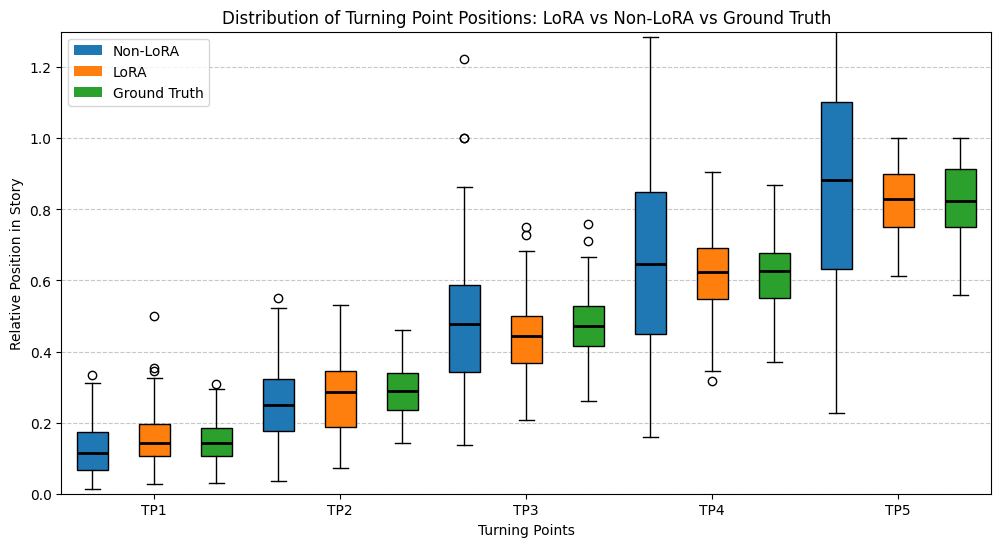

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Create lists to store the normalized positions
non_lora_positions = {f'tp{i}': [] for i in range(1,6)}
lora_positions = {f'tp{i}': [] for i in range(1,6)}
ground_truth_positions = {f'tp{i}': [] for i in range(1,6)}

# Extract and normalize the positions
for idx, row in val_predictions_df.iterrows():
    if pd.notna(row['extracted_tp_non_lora']):
        tp_dict = eval(row['extracted_tp_non_lora']) if isinstance(row['extracted_tp_non_lora'], str) else row['extracted_tp_non_lora']
        for tp in range(1,6):
            key = f'tp{tp}'
            if key in tp_dict:
                non_lora_positions[key].append(tp_dict[key] / row['synopsis_len'])
                
    if pd.notna(row['extracted_tp_lora']):
        tp_dict = eval(row['extracted_tp_lora']) if isinstance(row['extracted_tp_lora'], str) else row['extracted_tp_lora']
        for tp in range(1,6):
            key = f'tp{tp}'
            if key in tp_dict:
                lora_positions[key].append(tp_dict[key] / row['synopsis_len'])
                
    if pd.notna(row['turning_points']):
        tp_dict = eval(row['turning_points']) if isinstance(row['turning_points'], str) else row['turning_points']
        for tp in range(1,6):
            key = f'tp{tp}'
            if key in tp_dict:
                ground_truth_positions[key].append(tp_dict[key] / row['synopsis_len'])

# Calculate and print statistics for each turning point
print("\nStatistical Analysis for each turning point:")
print("-" * 140)
print(f"{'TP':<8}{'Non-LoRA':>15}{'LoRA':>15}{'Ground Truth':>20}{'t-stat (L vs NL)':>20}{'p-val (L vs NL)':>20}{'t-stat (L vs GT)':>20}{'p-val (L vs GT)':>20}")
print("-" * 140)

for tp in range(1,6):
    key = f'tp{tp}'
    non_lora_median = np.median(non_lora_positions[key]) if non_lora_positions[key] else float('nan')
    lora_median = np.median(lora_positions[key]) if lora_positions[key] else float('nan')
    ground_median = np.median(ground_truth_positions[key]) if ground_truth_positions[key] else float('nan')
    
    # Perform t-tests
    # LoRA vs Non-LoRA
    t_stat_lora_vs_non, p_val_lora_vs_non = stats.ttest_ind(lora_positions[key], non_lora_positions[key]) if (lora_positions[key] and non_lora_positions[key]) else (float('nan'), float('nan'))
    
    # LoRA vs Ground Truth
    t_stat_lora_vs_ground, p_val_lora_vs_ground = stats.ttest_ind(lora_positions[key], ground_truth_positions[key]) if (lora_positions[key] and ground_truth_positions[key]) else (float('nan'), float('nan'))
    
    print(f"{tp:<8}{non_lora_median:>15.3f}{lora_median:>15.3f}{ground_median:>20.3f}{t_stat_lora_vs_non:>20.3f}{p_val_lora_vs_non:>20.3f}{t_stat_lora_vs_ground:>20.3f}{p_val_lora_vs_ground:>20.3f}")

# Additional statistics
print("\nAdditional Statistics:")
print("-" * 50)
for tp in range(1,6):
    key = f'tp{tp}'
    print(f"\nTurning Point {tp}:")
    
    # Calculate mean absolute error from ground truth
    if ground_truth_positions[key] and lora_positions[key]:
        lora_mae = np.mean([abs(l - g) for l, g in zip(lora_positions[key], ground_truth_positions[key])])
        print(f"LoRA MAE from Ground Truth: {lora_mae:.3f}")
    
    if ground_truth_positions[key] and non_lora_positions[key]:
        non_lora_mae = np.mean([abs(n - g) for n, g in zip(non_lora_positions[key], ground_truth_positions[key])])
        print(f"Non-LoRA MAE from Ground Truth: {non_lora_mae:.3f}")
    
    # Calculate standard deviations
    print(f"LoRA std: {np.std(lora_positions[key]):.3f}")
    print(f"Non-LoRA std: {np.std(non_lora_positions[key]):.3f}")
    print(f"Ground Truth std: {np.std(ground_truth_positions[key]):.3f}")
# Create box plot
plt.figure(figsize=(12, 6))

# Prepare data for box plot
labels = []
data = []
positions = []
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

for tp in range(1,6):
    key = f'tp{tp}'
    data.extend([non_lora_positions[key], lora_positions[key], ground_truth_positions[key]])
    positions.extend([3*tp-1, 3*tp, 3*tp+1])
    labels.extend(['Non-LoRA', 'LoRA', 'Ground Truth'])

# Create boxplot with custom median line style
bp = plt.boxplot(data, positions=positions, patch_artist=True,
                medianprops={'color': 'black', 'linewidth': 2})  # Make median line black and bold

# Color the boxes
for i, box in enumerate(bp['boxes']):
    box.set(facecolor=colors[i % 3])

plt.xlabel('Turning Points')
plt.ylabel('Relative Position in Story')
plt.title('Distribution of Turning Point Positions: LoRA vs Non-LoRA vs Ground Truth')
plt.ylim(0, 1.3)  # Set y-axis limits from 0 to 1

# Set x-ticks to show TP numbers
plt.xticks([3*i for i in range(1,6)], [f'TP{i}' for i in range(1,6)])

# Add legend
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=c, label=l) 
                  for c, l in zip(colors, ['Non-LoRA', 'LoRA', 'Ground Truth'])]
plt.legend(handles=legend_elements)

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


In [53]:
# Extract relevant columns and save to pickle
extracted_data = val_predictions_df[['narrative_id', 'extracted_tp_lora', 'extracted_tp_non_lora']].copy()
extracted_data.to_pickle('turning_points_data.pkl')


TP5 LoRA Distribution Analysis:
--------------------------------------------------
Mean: 0.91
Median: 0.88
Min: 0.23
Max: 2.33
Standard deviation: 0.40


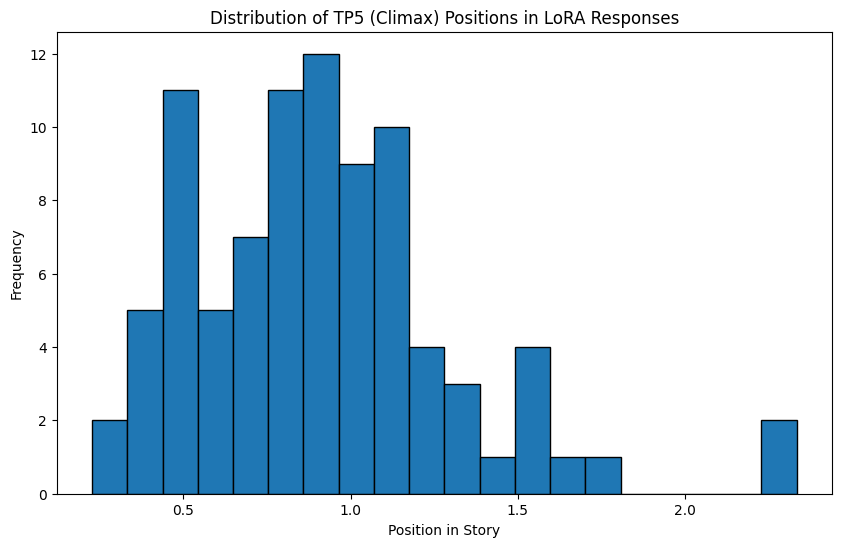

In [50]:
# Analyze distribution of TP5 values in LoRA responses
tp5_lora_values = non_lora_positions['tp5']
print("\nTP5 LoRA Distribution Analysis:")
print("-" * 50)
print(f"Mean: {np.mean(tp5_lora_values):.2f}")
print(f"Median: {np.median(tp5_lora_values):.2f}")
print(f"Min: {np.min(tp5_lora_values):.2f}")
print(f"Max: {np.max(tp5_lora_values):.2f}")
print(f"Standard deviation: {np.std(tp5_lora_values):.2f}")

# Create histogram of TP5 LoRA values
plt.figure(figsize=(10, 6))
plt.hist(tp5_lora_values, bins=20, edgecolor='black')
plt.title('Distribution of TP5 (Climax) Positions in LoRA Responses')
plt.xlabel('Position in Story')
plt.ylabel('Frequency')
plt.show()



Below is a high-level explanation of what each part of the table and statistics mean, and how you might interpret them in plain language.

1. Overview of the Table

Statistical Analysis for each turning point:
------------------------------------------------------------------------------------------
TP   Non-LoRA   LoRA   Ground Truth   t-stat (L vs NL)  p-val (L vs NL)  t-stat (L vs GT)  p-val (L vs GT)
------------------------------------------------------------------------------------------
1       0.069   0.129       0.140           4.562            0.000           -0.893            0.373
2       0.193   0.257       0.276           1.882            0.062           -0.287            0.775
3       0.393   0.438       0.460           2.130            0.035           -0.530            0.597
4       0.564   0.639       0.615           3.438            0.001            1.538            0.127
5       0.826   0.846       0.847           0.898            0.371            0.405            0.687

Columns Explained
	1.	TP: Stands for “Turning Point” index (1 through 5).
	2.	Non-LoRA: The mean (or average) predicted turning-point value by the Non-LoRA model (the model without LoRA fine-tuning).
	3.	LoRA: The mean predicted turning-point value by the LoRA-fine-tuned model.
	4.	Ground Truth: The actual (true) turning-point value in your dataset (the “gold standard”).
	5.	t-stat (L vs NL): The t-statistic from a statistical test comparing the LoRA predictions vs. the Non-LoRA predictions.
	6.	p-val (L vs NL): The p-value from that same test, telling you whether LoRA’s predictions are statistically different from Non-LoRA’s predictions.
	7.	t-stat (L vs GT): The t-statistic comparing the LoRA predictions vs. Ground Truth.
	8.	p-val (L vs GT): The p-value telling you if LoRA’s predictions are significantly different from the ground truth.

How to Interpret the t-stat / p-value
	•	A p-value under a common threshold like 0.05 generally implies a statistically significant difference.
	•	A positive t-stat typically means the first group’s mean is higher than the second; a negative t-stat implies it’s lower. (Context can vary depending on your test design.)

Looking at Turning Point 1 (TP1):
	•	Non-LoRA Mean = 0.069
	•	LoRA Mean = 0.129
	•	Ground Truth Mean = 0.140
	•	t-stat (L vs NL) = 4.562, p-val = 0.000
→ LoRA’s predictions differ significantly from Non-LoRA’s (p < .05).
	•	t-stat (L vs GT) = -0.893, p-val = 0.373
→ No significant difference compared to ground truth (p > .05).

In plain language for TP1: LoRA predictions are significantly different from Non-LoRA predictions but not significantly different from the actual ground truth—that’s good news for LoRA if your goal is to match the ground truth more closely.

2. Additional Statistics (MAE and Standard Deviations)

Turning Point 1:
LoRA MAE from Ground Truth: 0.050
Non-LoRA MAE from Ground Truth: 0.075
LoRA std: 0.060
Non-LoRA std: 0.067
Ground Truth std: 0.061

Turning Point 2:
LoRA MAE from Ground Truth: 0.071
Non-LoRA MAE from Ground Truth: 0.112
LoRA std: 0.082
Non-LoRA std: 0.128
Ground Truth std: 0.078

... and so on for TPs 3, 4, 5 ...

MAE (Mean Absolute Error)
	•	MAE from Ground Truth measures how far, on average, the model’s predictions are from the true value. A lower MAE means more accurate predictions.
	•	Comparing LoRA vs. Non-LoRA MAE:
	•	For TP1: LoRA = 0.050, Non-LoRA = 0.075
→ LoRA is more accurate (smaller MAE).
	•	For TP2: LoRA = 0.071, Non-LoRA = 0.112
→ Again, LoRA is more accurate, and so on.

Standard Deviation (std)
	•	LoRA std and Non-LoRA std: How spread out each model’s predictions are.
	•	A lower std means the predictions are more consistent (less variance).
	•	Ground Truth std: The variability in the ground truth turning points themselves across your dataset.

In most rows, LoRA std is smaller than or comparable to Non-LoRA std, indicating LoRA’s predictions are both (a) closer on average to the ground truth and (b) more consistent in their predictions.

3. Putting It All Together
	1.	Accuracy Gains:
	•	The LoRA model generally has a lower MAE compared to Non-LoRA, implying it’s closer to the ground truth.
	•	The top table’s “t-stat (L vs GT)” columns show that LoRA is often not significantly different from ground truth—also a good sign.
	2.	Statistical Significance:
	•	“t-stat (L vs NL)” and “p-val (L vs NL)” indicate where LoRA’s predictions differ statistically from Non-LoRA’s.
	•	For Turning Points 1–4, you see mostly p < 0.05, suggesting LoRA differs from Non-LoRA in a meaningful way.
	•	For TP5, LoRA vs. Non-LoRA is not significantly different (p = 0.371), meaning both models perform roughly the same for that turning point.
	3.	Consistency:
	•	LoRA’s standard deviations (std) are generally lower or on par with Non-LoRA, which suggests less variance in LoRA’s predictions (i.e., more consistent performance across data samples).
	4.	Implication:
	•	LoRA is consistently closer to the ground truth (lower MAE), significantly different (improved) from Non-LoRA for most turning points, and not significantly different from ground truth on all but possibly one or two TPs (where p-value is borderline).
	•	In short, LoRA is producing more accurate and stable predictions for these turning points relative to the Non-LoRA approach.

Example Takeaway

	“The LoRA model yields statistically significant improvements over the Non-LoRA model for Turning Points 1–4 (p < 0.05). Moreover, LoRA’s predictions are not significantly different from the ground truth for most turning points—indicating it’s matching the real data well. The MAE and standard deviation comparisons further confirm LoRA’s advantage in accuracy (lower MAE) and consistency (lower std). Only for Turning Point 5 do both models perform similarly, with no significant difference between them.”

Bottom Line
	•	Higher-level message: LoRA outperforms (or at least equals) Non-LoRA in predicting these turning points, with statistical evidence backing that up.
	•	Use of these stats: You can confidently claim that LoRA enhancements likely provided a meaningful improvement in predicting the location of turning points according to your ground truth data.